In [1]:
import numpy as np
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import glob
import imageio
import matplotlib.pyplot as plt
import os
import time
import re

from PIL import Image
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow_examples.models.pix2pix import pix2pix
from IPython import display

c:\Users\hokut\デスクトップ\practice\kaggle\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for k in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[k], True)
        print('memory growth:', tf.config.experimental.get_memory_growth(physical_devices[k]))
else:
    print("Not enough GPU hardware devices available")

memory growth: True


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
MONET_IMG_PATH = "./data/monet_jpg/"
MONET_TFREC_PATH = "./data/monet_tfrec/"
PHOTO_IMG_PATH = "./data/photo_jpg/"
PHOTO_TFREC_PATH = "./data/photo_tfrec/"

In [5]:
EPOCH = 100
SIZE = 256
RESIZE = 128
BATCH_SIZE = 16

In [6]:
monet_files = tf.io.gfile.glob(os.path.join(MONET_TFREC_PATH, "*.tfrec"))
photo_files = tf.io.gfile.glob(os.path.join(PHOTO_TFREC_PATH, "*.tfrec"))

print(f"Monet tfrecord files: {len(monet_files)}")
print(f"photo tfrecord files: {len(photo_files)}")


Monet tfrecord files: 5
photo tfrecord files: 20


In [7]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[RESIZE, RESIZE, 3])

    return cropped_image


def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    # check
    print(f"p_spatial: {p_spatial}")
    print(f"p_rotate: {p_rotate}")

    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotated image to 90 degrees for 3 times
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotated image to 90 degrees for 2 times
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate image to 90 degrees for single
    
    image = tf.image.random_flip_left_right(image) # With a 1 in 2 chance, outputs the contents of image flipped along the second dimension, which is width
    image = tf.image.random_flip_up_down(image) # With a 1 in 2 chance, outputs the contents of image flipped along the first dimension, which is height

    if p_spatial > .75:
        image = tf.image.transpose(image)
    
    image = tf.image.random_crop(image, size=[RESIZE, RESIZE, 1])

    return image

In [8]:
IMAGE_SIZE = [SIZE, SIZE]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image 

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, tfrecord_format)

    # check
    print(example)

    image = decode_image(example['image']) # (256, 256, 3)

    return image

In [9]:
def load_dataset(filenames, apply_jitter=False, repeat=True, shuffle=True, batch_size=BATCH_SIZE):

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)

    if apply_jitter:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)

    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

In [10]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]

    return np.sum(n)

In [11]:
n_monet_samples = count_data_items(monet_files)

n_photo_samples = count_data_items(photo_files)

In [12]:
print(n_monet_samples)

print(n_photo_samples)

300
7038


In [13]:
monet_ds = load_dataset(monet_files, apply_jitter=True)
photo_ds = load_dataset(photo_files, apply_jitter=True)

photo_ds_test = load_dataset(photo_files, repeat=False, shuffle=False, batch_size=1)

{'image': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=() dtype=string>, 'image_name': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=() dtype=string>, 'target': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=() dtype=string>}
p_spatial: Tensor("random_uniform/Mul:0", shape=(), dtype=float32)
p_rotate: Tensor("random_uniform_1/Mul:0", shape=(), dtype=float32)
{'image': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=() dtype=string>, 'image_name': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=() dtype=string>, 'target': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=() dtype=string>}
p_spatial: Tensor("random_uniform/Mul:0", shape=(), dtype=float32)
p_rotate: Tensor("random_uniform_1/Mul:0", shape=(), dtype=float32)
{'image': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=() dtype=string>, 'image_name': <tf.Tensor 'ParseSingleExample/Parse

In [14]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

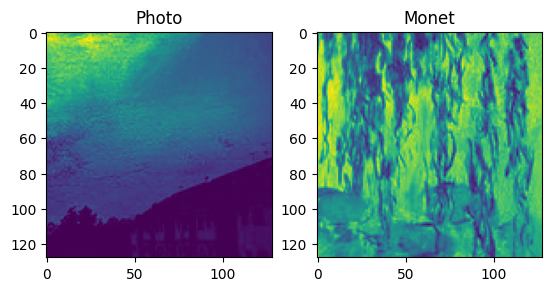

In [15]:
plt.subplot(121)
plt.title('Photo')

plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')

plt.imshow(example_monet[0] * 0.5 + 0.5)

In [16]:
def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    
    return x

def randbrightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude

    return x

def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = ( x - x_mean) * magnitude + x_mean

    return x

def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    
    return x

In [17]:
def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)

    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)

    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1) # min: 0, max: image_size[0] + 1 value array
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1) # min: 0, max: image_size[0] + 1 value array

    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])

    return x

def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)

    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)

    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')

    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)

    x = x * tf.expand_dims(mask, axis=3) # similar squeeze()

    return x



In [18]:
AUGMENT_FNS = {
    'color': [randbrightness, rand_saturation],
    'translation': [rand_translation],
    'cutout': [rand_cutout]
}

def aug_fn(image):
    return DiffAugment(image, "translation,cutout")

In [19]:
both_images = tf.concat([example_monet, example_photo], axis=0)
aug_images = aug_fn(both_images)
aug_monet, aug_photo = tf.split(aug_images, num_or_size_splits=2, axis=0)

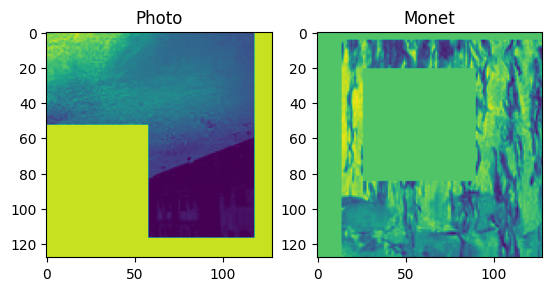

In [20]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(aug_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(aug_monet[0] * 0.5 + 0.5)


In [21]:
# ResNet Generator
def Downsample(X, filter_count, kernel_size, padding, stride, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    X = tf.keras.layers.ZeroPadding2D((padding, padding))(X)
    X = tf.keras.layers.Conv2D(filter_count, (kernel_size, kernel_size), padding='valid', strides=(stride, stride), kernel_initializer=initializer, use_bias=False)(X)

    if apply_norm:
        X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    
    X = tf.keras.layers.LeakyReLU()(X)

    return X

def Upsample(X, filter_count, kernel_size, stride, activation='relu', apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    X = tf.keras.layers.Conv2DTranspose(filter_count, (kernel_size, kernel_size), padding='same', strides=(stride, stride), kernel_initializer=initializer, use_bias=False)(X)

    if apply_norm:
        X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    
    X = tf.keras.layers.Activation(activation)(X)

    return X


In [22]:
def ResidualBlock(X):
    initalizer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    X_shortcut = X

    X = tf.keras.layers.ZeroPadding2D((1, 1))(X)
    X = tf.keras.layers.Conv2D(256, (3, 3), padding='valid', strides=(1,1), kernel_initializer=initalizer, use_bias=False)(X)
    X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    X = tf.keras.layers.Activation('relu')(X)

    X = tf.keras.layers.ZeroPadding2D((1, 1))(X)
    X = tf.keras.layers.Conv2D(256, (3, 3), padding='valid', strides=(1,1), kernel_initializer=initalizer, use_bias=False)(X)
    X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)

    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)

    return X


In [23]:
def ResNetGenerator(height=SIZE, width=SIZE):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    X_input = tf.keras.layers.Input((height, width, 3))

    skips = []

    X = Downsample(X_input, 64, 7, 3, 1, apply_norm=False)
    skips.append(X)

    X = Downsample(X, 128, 3, 1, 2)
    skips.append(X)

    X = Downsample(X, 256, 3, 1, 2)

    for _ in range(6):
        X = ResidualBlock(X)

    skips = list(reversed(skips))
    
    X = Upsample(X, 128, 4, 2)
    X = tf.keras.layers.Concatenate()([X, skips[0]])

    X = Upsample(X, 64, 4, 2)
    X = tf.keras.layers.Concatenate()([X, skips[1]])

    X = Upsample(X, 3, 7, 1, activation='tanh', apply_norm=False)

    model = tf.keras.models.Model(inputs=X_input, outputs=X)

    return model

In [24]:
generator = ResNetGenerator()
generator.summary()

c:\Users\hokut\デスクトップ\practice\kaggle\.venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 128, 128, 128), (None, 256, 256, 64)]

In [ ]:
def Discriminator(height=SIZE, width=SIZE):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_input = tf.keras.layers.Input((height, width, 3))

    X = Downsample(X_input, 64, 4, 1, 2, apply_norm=False)
    X = Downsample(X, 128, 4, 1, 2)
    X = Downsample(X, 256, 4, 1, 2)
    X = Downsample(X, 512, 4, 1, 1)
    
    X = tf.keras.layers.ZeroPadding2D()(X)
    X = tf.keras.layers.Conv2D(1, (4,4), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)   
    X = tf.keras.layers.Activation('sigmoid')(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)

    return model

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 zero_padding2d_15 (ZeroPadd  (None, 258, 258, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      3072      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 zero_padding2d_16 (ZeroPadd  (None, 130, 130, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 128)       1310

In [ ]:
monet_generator = ResNetGenerator(height=None, width=None)

photo_generator = ResNetGenerator(height=None, width=None)

monet_discriminator = Discriminator(height=None, width=None)

photo_discriminator = Discriminator(height=None, width=None)

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(121)
plt.title('Original Photo')
plt.imshow(aug_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet-esque Photo')
plt.imshow(to_monet[0] * 0.5 + 0.5)

ValueError: Exception encountered when calling layer "model_2" "                 f"(type Functional).

Input 0 of layer "conv2d_20" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (16, 134, 134, 1)

Call arguments received by layer "model_2" "                 f"(type Functional):
  • inputs=tf.Tensor(shape=(16, 128, 128, 1), dtype=float32)
  • training=None
  • mask=None